# Word2vec-Pipeline Ru
#### Здесь приведён пайплайн работы с корпусами текстов для извлечения из них экстрактивной 
#### сумаризации методом word2vec.

In [ ]:
import pandas as pd
import numpy as np
import string
from navec import Navec
from slovnet.model.emb import NavecEmbedding
from pathlib import Path
from tg.projects.retell.retell_utils.corpora_sugar import CorpusSugar
from tg.projects.retell.retell_utils.metrics import get_cosine_sim, get_jaccard_index,show_statistics_and_bar, plot_confint
from tg.grammar_ru.corpus import CorpusReader
from tg.common._common import DataBundle
import tg.projects.retell.retell_utils.embeddings as embeding_utils
import tg.projects.retell.retell_utils.word2vec as word2vec_utils
from tg.common.analysis import Bootstrap, Aggregators, grbar_plot

## CorpusReader
#### Используется для того, чтобы извлечь корпус текстов из zip архива.
- Директория retell.corpuses хранит в себе исходные корпуса текстов.
- Директория retell.featurized_corpuses хранит в себе фичуризованные (с помощью slovnet,pymorphy) корпуса текстов.

In [3]:
retell_corpus = CorpusReader(Path("../../featurized_corpuses/All retell.featurized.retell.corpus.zip"))
text_corpus = CorpusReader(Path("../../featurized_corpuses/books.featurized.zip"))

## CorpusSugar
#### Класс, через который можно удобно работать с информацией внутри корпуса.
###### Создаём экземпляр класса. 
С помощью метода get_books_retell_info_by_author получаем все произведения автора из корпуса по главам в форматах:
 - книга, 
 - пересказ, 
 - короткий пересказ.

In [4]:
corpus_sugar = CorpusSugar(text_corpus, retell_corpus)
books, retell_books, summar_books = corpus_sugar.get_books_retell_info_by_author('Мартин')

In [5]:
books[0]

,filename,timestamp,part_index,token_count,character_count,ordinal,header_0,header_1,headers,genre,original_language,author,series,volume,max_id,header_2,header_3
file_id,,,,,,,,,,,,,,,,,
57af3a88-680a-43d4-a022-09bc23026182,fantasy/en/Мартин-ПЛИО-3.md,2022-10-14 22:07:27.516905,1,6444,26175,1630,ДЖОРДЖ МАРТИН / БУРЯ МЕЧЕЙ,ПРОЛОГ,ДЖОРДЖ МАРТИН / БУРЯ МЕЧЕЙ / ПРОЛОГ,fantasy,en,Мартин,ПЛИО,3,22854000,None,None
baddd09c-556f-4cb6-a122-090a65b6fb86,fantasy/en/Мартин-ПЛИО-3.md,2022-10-14 22:07:27.567581,2,5413,22673,1631,ДЖОРДЖ МАРТИН / БУРЯ МЕЧЕЙ,ДЖЕЙМЕ,ДЖОРДЖ МАРТИН / БУРЯ МЕЧЕЙ / ДЖЕЙМЕ,fantasy,en,Мартин,ПЛИО,3,22869413,None,None
2d517c70-9c1c-46ed-8a6c-8bfbef138aaf,fantasy/en/Мартин-ПЛИО-3.md,2022-10-14 22:07:27.612893,3,3679,14847,1632,ДЖОРДЖ МАРТИН / БУРЯ МЕЧЕЙ,КЕЙТИЛИН,ДЖОРДЖ МАРТИН / БУРЯ МЕЧЕЙ / КЕЙТИЛИН,fantasy,en,Мартин,ПЛИО,3,22883092,None,None
3073ab42-6a53-4056-ab81-a44ebaf9639c,fantasy/en/Мартин-ПЛИО-3.md,2022-10-14 22:07:27.643395,4,3622,14496,1633,ДЖОРДЖ МАРТИН / БУРЯ МЕЧЕЙ,АРЬЯ,ДЖОРДЖ МАРТИН / БУРЯ МЕЧЕЙ / АРЬЯ,fantasy,en,Мартин,ПЛИО,3,22896714,None,None
02ea2a22-1727-45ed-b1a9-06f9c8230e3a,fantasy/en/Мартин-ПЛИО-3.md,2022-10-14 22:07:27.673369,5,5379,21861,1634,ДЖОРДЖ МАРТИН / БУРЯ МЕЧЕЙ,ТИРИОН,ДЖОРДЖ МАРТИН / БУРЯ МЕЧЕЙ / ТИРИОН,fantasy,en,Мартин,ПЛИО,3,22912093,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4af9c962-e1af-411e-bd3b-c3383858043a,fantasy/en/Мартин-ПЛИО-3.md,2022-10-14 22:07:29.691160,78,4218,16646,1707,ДЖОРДЖ МАРТИН / БУРЯ МЕЧЕЙ,ТИРИОН,ДЖОРДЖ МАРТИН / БУРЯ МЕЧЕЙ / ТИРИОН,fantasy,en,Мартин,ПЛИО,3,24016159,None,None
bbcfdeee-4cc3-4d10-9a27-5775f76f3147,fantasy/en/Мартин-ПЛИО-3.md,2022-10-14 22:07:29.715334,79,4735,19345,1708,ДЖОРДЖ МАРТИН / БУРЯ МЕЧЕЙ,СЭМВЕЛ,ДЖОРДЖ МАРТИН / БУРЯ МЕЧЕЙ / СЭМВЕЛ,fantasy,en,Мартин,ПЛИО,3,24030894,None,None
ff972aa0-cc17-4040-bb46-cf76b39dcbf4,fantasy/en/Мартин-ПЛИО-3.md,2022-10-14 22:07:29.741058,80,3857,15667,1709,ДЖОРДЖ МАРТИН / БУРЯ МЕЧЕЙ,ДЖОН,ДЖОРДЖ МАРТИН / БУРЯ МЕЧЕЙ / ДЖОН,fantasy,en,Мартин,ПЛИО,3,24044751,None,None


## Загрузка эмбединга слов
### В проекте для произведений Мартина используется два типа эмбедингов:
- Библиотека Navec
- Дообученные на авторской лексике вектора

### Navec
#### Загружаем модель navec
Используем библиотеку для создания эмбедера слов.

In [7]:
model_path = Path("./_for_word2vec/navec_hudlit_v1_12B_500K_300d_100q.tar")
navec = Navec.load(model_path)
embeder = NavecEmbedding(navec)

/home/mixailkys/anaconda3/envs/grammar_ru/lib/python3.8/site-packages/slovnet/model/emb.py:46: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /opt/conda/conda-bld/pytorch_1678402316912/work/torch/csrc/utils/tensor_numpy.cpp:206.)
  torch.from_numpy(navec.pq.indexes),


### Дообученные вектора
#### Загружаем через databundle, извлекаем из него вектора
- Получаем словарь эмбедингов 
- Получаем вектора

In [9]:
db = DataBundle.load('../_for_word2vec/Martin-bundle.zip')
martin_spec_word_vocab = db.words.set_index('word').nf_n.to_dict()
better_fine_tuned_vec = pd.read_csv(Path("../_for_word2vec/Martin-better.csv"), sep='\t').iloc[:, 1:]

## Ban words
#### Создаём set из банвордов.
Здесь - различные вариации знаков пунктуации у Мартина.

In [10]:
ban_words = set(string.punctuation + "«—»…")
ban_words.update(["!!", "!?", "?!", "??", "?.."])

## Word2vec_utils
#### Извлекаем экстрактивный пересказ
С помощью stat_utils.get_extract_retell_by_common_word мы извлекаем пересказ статистическим методом.
 - Передаем текст для извлечения пересказа
 - Функцию, которая извлекает предложения из корпуса
 - Эмбедер
 - Векторайзер
 - Словарь
 - Детальность пересказа (итоговое число предложений)
  - Банворды 

In [11]:
fine_tuned_extract_retell = word2vec_utils.get_extract_retell(books[:1],corpus_sugar.get_sentences,embeding_utils.get_vocab_embedding,better_fine_tuned_vec,martin_spec_word_vocab,ban_words=ban_words)

  0%|          | 0/82 [00:00<?, ?it/s]

In [12]:
navec_extract_retell = word2vec_utils.get_extract_retell(books[:1],corpus_sugar.get_sentences,embeding_utils.get_vocab_embedding,embeder,navec.vocab,ban_words=ban_words)

  0%|          | 0/82 [00:00<?, ?it/s]

## True_retell
#### Получаем пересказ, написанный человеком.
Указываем в агрументах:
- Имя автора
- Тип пересказа (retell - пересказ, summary - краткий пересказ)
- Детальность пересказа (число предложений)

In [13]:
true_retell = corpus_sugar.get_true_retell('Мартин',"retell",retell_detail=5)

## Metrics
#### Получаем значение метрик схожести машинного и человеческого пересказа:
- Индекс Жаккара
- Косинусное расстояние

In [14]:
fine_tuned_jaccard_sim = np.array([get_jaccard_index(fine_tuned_extract_retell[i],true_retell[i]) for i in range(len(true_retell))])
fine_tuned_cos_sim = np.array([get_cosine_sim(fine_tuned_extract_retell[i],true_retell[i]) for i in range(len(true_retell))])

navec_jaccard_sim = np.array([get_jaccard_index(navec_extract_retell[i],true_retell[i]) for i in range(len(true_retell))])
navec_cos_sim = np.array([get_cosine_sim(navec_extract_retell[i],true_retell[i]) for i in range(len(true_retell))])

- #### Выводим значения метрик по главам в виде гистограммы, статистики метрик.
- #### Изображаем доверительный интервал для метрик.

Дообученные вектора
median Индекс Жаккара: 0.09
max Индекс Жаккара: 0.172
min Индекс Жаккара: 0.037
------------------------------------
median Косинусное расстояние: 0.156
max Косинусное расстояние: 0.413
min Косинусное расстояние: 0.028
------------------------------------


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/mixailkys/PycharmProjects/grammar_ru/tg/common/ml/miscellaneous/kraken.py:184: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(pd_result)
/home/mixailkys/PycharmProjects/grammar_ru/tg/common/ml/miscellaneous/kraken.py:184: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(pd_result)
/home/mixailkys/PycharmProjects/grammar_ru/tg/common/ml/miscellaneous/kraken.py:184: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(pd_result)
/home/mixailkys/PycharmProjects/grammar_ru/tg/common/ml/miscellaneous/kraken.py:184: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.ap

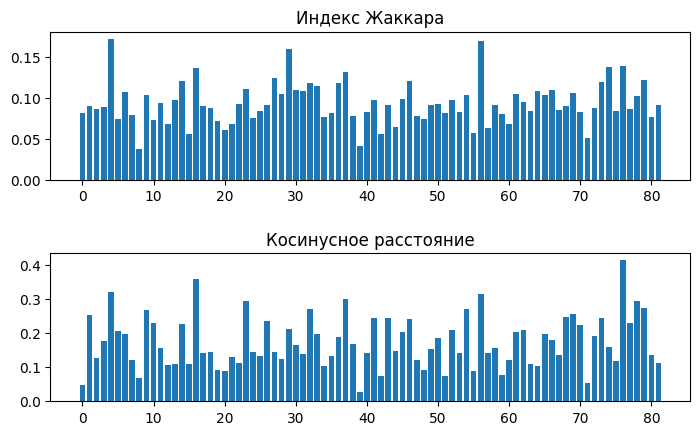

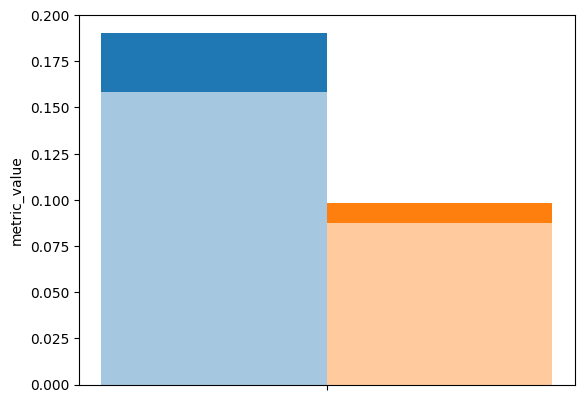

In [15]:
print("Дообученные вектора")
show_statistics_and_bar(fine_tuned_jaccard_sim,fine_tuned_cos_sim)
plot_confint(fine_tuned_jaccard_sim,fine_tuned_cos_sim)

Navec вектора
median Индекс Жаккара: 0.091
max Индекс Жаккара: 0.182
min Индекс Жаккара: 0.039
------------------------------------
median Косинусное расстояние: 0.167
max Косинусное расстояние: 0.381
min Косинусное расстояние: 0.013
------------------------------------


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/mixailkys/PycharmProjects/grammar_ru/tg/common/ml/miscellaneous/kraken.py:184: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(pd_result)
/home/mixailkys/PycharmProjects/grammar_ru/tg/common/ml/miscellaneous/kraken.py:184: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(pd_result)
/home/mixailkys/PycharmProjects/grammar_ru/tg/common/ml/miscellaneous/kraken.py:184: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(pd_result)
/home/mixailkys/PycharmProjects/grammar_ru/tg/common/ml/miscellaneous/kraken.py:184: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.ap

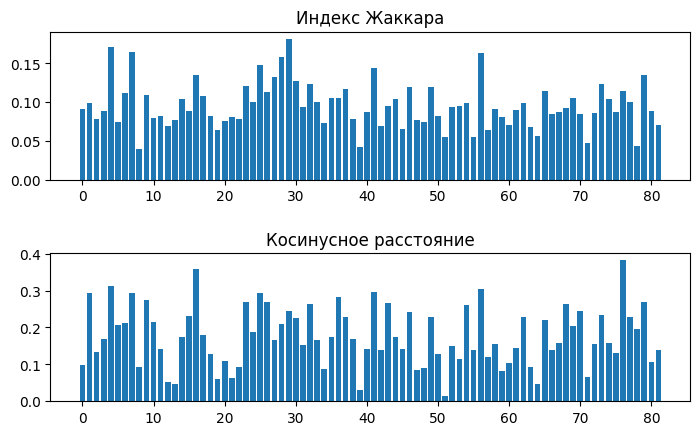

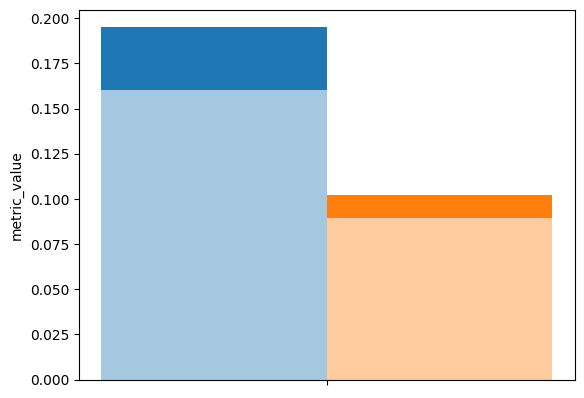

In [16]:
print("Navec вектора")
show_statistics_and_bar(navec_jaccard_sim,navec_cos_sim)
plot_confint(navec_jaccard_sim,navec_cos_sim)